In [1]:
from mammoth import *

## I will build time series data by myself

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

seq_len = 1000
x = np.arange(seq_len)

series_1 = (np.log2(np.arange(seq_len)+1)+2*np.arange(seq_len)**0.5+
            4*np.sin(0.2*(x+1))+5*np.cos(x+12)+7*np.cos(0.04*(x-8))+
            np.random.random(seq_len)*5.5)
series_1 = pd.DataFrame({'series_key':['series_1']*seq_len, 
                         'time_idx':x,
                         'y':series_1,
                         'sin_wx':np.sin(0.2*(x+1)),
                         'cos_wx':np.cos(x+12)})

series_2 = (0.0002*(np.arange(seq_len)-400)**2+40+
            7*np.sin(0.5*(x+1))+10*np.cos(0.1*x)-4*np.cos(0.9*(x-20))+20*np.sin(0.02*(x+4))+
            np.random.random(seq_len)*5)
series_2 = pd.DataFrame({'series_key':['series_2']*seq_len, 
                         'time_idx':x,
                         'y':series_2,
                         'sin_wx':np.sin(0.02*(x+4)),
                         'cos_wx':np.cos(0.9*(x-20))})

series_3 = (np.log2(200-10*np.arange(seq_len)**0.2)**3/10+
            3*np.sin(0.05*(x-9))+2*np.sin(0.01*x)-np.cos(8*(x-10))-3*np.sin(0.2*(x+40))+
            np.random.random(seq_len)*4)
series_3 = pd.DataFrame({'series_key':['series_3']*seq_len, 
                         'time_idx':x,
                         'y':series_3,
                         'sin_wx':np.sin(0.01*x),
                         'cos_wx':np.cos(8*(x-10))})

data = pd.concat([series_1, series_2, series_3], ignore_index=True)
data['key_embed'] = data['series_key'].copy()

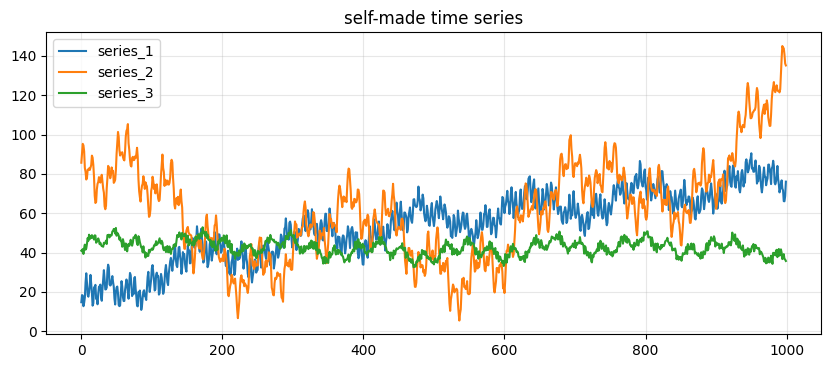

In [3]:
plt.figure(figsize=(10,4), dpi=100)
for key in data['series_key'].unique():
    plt.plot(data[data['series_key']==key]['y'].values, label=key)
plt.legend()
plt.grid(alpha=0.3)
plt.title('self-made time series')
plt.show()

# Build dataset for training and forecasting
***

<font size=4>**dsbuilder** is the function to generate dataset for train, validation and forecast.</font>

***
<font size=3>***input_settings*** is a dictionary contains the basic settings for preprocessing.</font>

Required keys for 'input_settings' are as follows:

* `seq_key` $<List/string/integer>$ The primary key of time series.
* `seq_label` $<List/string/integer>$ The columns to identity the time sequence, such as calendar date or cumulative number.
* `seq_target` $<List/string/integer>$ The target to predict.
* `perc_horizon` $<integer>$ The size of looking back window, which means how long of historical data you will refer to.
* `fcst_horizon` $<integer>$ The prediction length.
        
Alternative keys for 'input_settings' are as follows:
* `enc_feat` $<List>$ The name of features used in the encoding part. default: [].
* `dec_feat` $<List>$ The name of features used in the decoding part. default: [].
* `embed_feat` $<List>$ The name of embedding features. default: [].
* `norm_feat` $<dictionary>$ The features you want to normalize. It is recommended to define 'norm_feat' within 'single_tsm' function. When you define 'norm_feat' here, there won't be trainable weights on mean and standard deviation. default: {}.
* `min_avail_perc_rate` $<float>$ The minimum rate of padding time points verus perception horizon. When exceeded, the data at that time point will be padded. default: 0.25.
* `min_avail_seq_rate` $<float>$ The minimum rate of padding time points verus each time series. Exceeded time series won't be trained. default: 0.5.
* `window_freq` $<integer>$ The strides of sliding window to get time series pieces. default: 1.
* `val_rate` $<float>$ The rate of validation part in train data. If None, no validation data will be built. default: None

***
<font size=3>***train_settings*** is a dictionary contains the basic settings for training.</font>

Alternative settings are as follows:

* `optimizer` The optimizer function. It can either be a function in 'tensorflow.keras.optimizers' or the string representing the function. For detail, please refer to tensorflow.keras tutorial. default: 'adam'.
* `learning_rate` default: 0.01.
* `loss_func` It can be a python func(refer to tensorflow.keras tutorial for how to build self-defined Loss Function or string. Also it can be any iterable object(e.g. 'list' or 'tuple') containing different losses(e.g. ['mae','mse']). default: 'mae'.
* `loss_weights` Same parameter in 'tensorflow.keras.model.Model.compile'. default: None.
* `weighted_metrics` Same parameter in 'tensorflow.keras.model.Model.compile'. default: ['mae', PearsonCoef].
* `batch_size` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 16.
* `epochs` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 1000.
* `callbacks` Same parameter in 'tensorflow.keras.model.Model.fit'. For detail in defining your own callback functino, please refer to 'tensorflow.keras.callbacks'. default: [EarlyStopping(monitor='loss', patience=10)].
* `verbose` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 1.
* `validation_steps` Same parameter in 'tensorflow.keras.model.Model.fit'. default: None.
* `validation_batch_size` Same parameter in 'tensorflow.keras.model.Model.fit'. default: None.
* `validation_freq` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 1.
* `use_multiprocessing` Same parameter in 'tensorflow.keras.model.Model.fit'. Note that: 'multiprocessing' is not available when used GPU numbers < 2 or tensorflow version < 2.5.0. default: True. 
* `shuffle` Same parameter in 'tensorflow.keras.model.Model.fit'. default: True.

***
Callable Arguments:
* `train_data` $<pandas.DataFrame>$ The dataframe used for training.
* `fcst_data` $<pandas.DataFrame>$ The dataframe used for forecasting.
* `embed_data` $<pandas.DataFrame>$ The dataframe used for embedding.

***
Return:
* `train_dataset` $<tensorflow.data.Dataset>$ Dataset for training.
* `val_dataset` $<tensorflow.data.Dataset>$ Dataset for validation.
* `fcst_dataset` $<tensorflow.data.Dataset>$ Dataset for forecasting.
* `input_settings` $<dictionary>$ Updated input_settings.
* `prediction` $<pandas.DataFrame>$ The primary key frame of forecast, including seq_key and seq_label.

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from mammoth.losses import PearsonCoef
tf_ignore_warnings() ## Ignore warnings

## define input_settings
input_settings = {'seq_key':['series_key'],
                  'seq_label':['time_idx'],
                  'seq_target':['y'],
                  'perc_horizon':256,'fcst_horizon':64,
                  'enc_feat':['sin_wx', 'cos_wx'], 
                  'dec_feat':['sin_wx', 'cos_wx'], 
                  'embed_feat':['key_embed'],
                  'val_rate':0.25, 'window_freq':2}

## define train_settings
train_settings = {'learning_rate':0.01, 'loss_func':'mae', 'batch_size':3,
                  'weighted_metrics':['mae',PearsonCoef],
                  'epochs':200, 'callbacks':[EarlyStopping(monitor='val_loss', patience=10)],
                  'use_multiprocessing':False}

train_data = data[data['time_idx']<=900]
fcst_data = data[data['time_idx']>900]
embed_data = data[input_settings['seq_key']+input_settings['embed_feat']].drop_duplicates()

## Use 'dsbuilder' to create datasets for training, validation and forecasting
train_dataset,\
val_dataset,\
fcst_dataset, \
input_settings, \
prediction = dsbuilder(input_settings)(train_data, fcst_data, embed_data)

## Build time series models
***

<font size=4>**signle_tsm** is the function to generate single time series model.</font>

***
<font size=3>**Arguments**</font>

***input_settings*** \
See the tutourials above.

***train_settings*** \
See the tutourials above.

***embedding*** \
A dictionary whose key is the method of embedding, normally string type, and value is also a dictionary which contains the hyperparameter for embedding(e.g. {'SimpleEmbedding':{'n_embed_layers':2}}).
The builtin embedding is called 'SimpleEmbedding'. For customized embedding function, please refer to `mammoth.model.nn_blocks.ModelBlock`. default: {'SimpleEmbedding':{}}.
        
***encoder*** \
A dictionary whose key is the method of time series encoding, normally string type, and value is also a dictionary which contains the hyperparameter for encoding(e.g. {'WavenetEncoder':{'n_enc_filters':8, 'n_enc_layers':6}}).
There are 4 builtin encoding methods:
* `WavenetEncoder` -> https://arxiv.org/pdf/1609.03499v2.pdf
* `TransformerEncoder` -> https://arxiv.org/pdf/1706.03762v5.pdf
* `InformerEncoder` -> https://arxiv.org/pdf/2012.07436v3.pdf
* `SciEncoder` -> https://arxiv.org/pdf/2106.09305v3.pdf

For customized encoding function, please refer to `mammoth.model.nn_blocks.ModelBlock`. default: {'WavenetEncoder':{}}.
        
***decoder*** \
A dictionary whose key is the method of time series decoding, normally string type, and value is also a dictionary which contains the hyperparameter for decoding(e.g. {'DenseDecoder':{'dec_activation':'elu'}}).
There are 2 builtin decoding methods:
* `DenseDecoder` -> The most common decoding methods. Using fully connected layers after the encoder part to get decoder part.
* `CaCtDecoder` -> https://arxiv.org/pdf/1711.11053v2.pdf

For customized decoding function, please refer to mammoth.model.nn_blocks.ModelBlock. default: {'DenseDecoder':{}}.

***recoder*** \
A dictionary whose key is the method of time series reverse encoding, normally string type, and value is also a dictionary which contains the hyperparameter for reverse encoding(e.g. {'ConvRecoder':{'n_rec_layers':2}}). Reverse encoding is used in multi-horizon forecasting. When you have enough future information and use them as the latent features, you can reverse encode the future information to its relative past time points.
There are 1 builtin reverse encoding method:
* `ConvRecoder` -> Use convolution to encode future information to now reversely.

For customized reverse encoding function, please refer to mammoth.model.nn_blocks.ModelBlock. default: {'ConvRecoder':{}}.
        
***output*** \
A dictionary whose key is the method of output, normally string type, and value is also a dictionary which contains the hyperparameter for output(e.g. {'MlpOutput':{'mlp_dims':[16,8]}}).
There are 3 builtin output methods:
* `MlpOutput` -> The most common output methods. Just use several fully connected layers to get the final output.
* `AttentionOutput` -> The attention mechanism applied on the feature dimension. Usually used in attention-related models, e.g. Informer.
* `TabnetOutput` -> Using TabNet for the final regression or classification. For TabNet, please refer to https://arxiv.org/pdf/1908.07442v5.pdf.

***is_fork*** \
Whether use fork training. Fork training is only available to RNN-based and RNN-based models, e.g. 'WaveNet' and 'SCINet'. Fork training can save memory and speed up training process.
        
***norm_feat*** \
A dictionary whose key is the normalization methods, and value is a iterable object that contains features you want to normalize. e.g. {'standard':['f1', 'f2']}. There are 4 normalization methods:
* `standard`: $\frac{x-avg(x)}{std(x)}$
* `minmax`: $\frac{x-min(x)}{max(x)-min(x)}$
* `mean`: $\frac{x}{avg(x)}$
* `maxabs`: $\frac{x}{max(abs(x))}$

Note that: the target will be normalized using `RevIN` automatically. Thus you don't need to declare the target in 'norm_feat'. For `RevIN`, please refer to https://openreview.net/pdf?id=cGDAkQo1C0p. default: None.

***perc_horizon*** \
The length of looking back window. If None, it will be the same with that defined in 'input_settings'. If not None, the value will replace the original 'perc_horizon' defined in 'input_settings'. default: None.

***
<font size=3>**Return**</font>

The untrained model with object type `ModelBase`

In [24]:
## Here take 'Transformer' as an example

film = single_tsm(input_settings, train_settings, 
                  embedding = {'SimpleEmbedding':{'embed_out_dim':2}}, 
                  encoder = {'FilmEncoder':{'multiscale':[1,2,4], 'compression':8}}, 
                  decoder = {'DenseDecoder':{}}, 
                  recoder = None, 
                  output = {'MlpOutput':{'mlp_dims':[16,8]}},
                  norm_feat = {},
                  perc_horizon = 256)
film.summary()

Model: "ts_model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 676, 3)]     0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 676, 1)]     0           []                               
                                                                                                  
 MovingWindowTransform_7 (Movin  ((None, 338, 256, 3  0          ['input_43[0][0]',               
 gWindowTransform)              ),                                'input_44[0][0]']               
                                 (None, 338, 64, 2)                                               
                                , (None, 338, 256,                                      

## Train the time series model

In [25]:
film.fit(train_dataset, val_dataset)

Epoch 1/200
1/1 [==============================] - 330s 330s/step - loss: 9.3672 - mae: 11.7128 - PearsonCoef: 0.1461 - val_loss: 8.1107 - val_mae: 9.4486 - val_PearsonCoef: -0.1248
Epoch 2/200
1/1 [==============================] - 315s 315s/step - loss: 8.6626 - mae: 10.8317 - PearsonCoef: 0.1754 - val_loss: 7.9481 - val_mae: 9.2591 - val_PearsonCoef: -0.1219
Epoch 3/200
1/1 [==============================] - 307s 307s/step - loss: 8.4991 - mae: 10.6273 - PearsonCoef: 0.1967 - val_loss: 7.9668 - val_mae: 9.2809 - val_PearsonCoef: -0.1185
Epoch 4/200
1/1 [==============================] - 286s 286s/step - loss: 8.3992 - mae: 10.5025 - PearsonCoef: 0.2071 - val_loss: 8.0907 - val_mae: 9.4253 - val_PearsonCoef: -0.1150
Epoch 5/200
1/1 [==============================] - 267s 267s/step - loss: 8.1930 - mae: 10.2446 - PearsonCoef: 0.2128 - val_loss: 8.2758 - val_mae: 9.6409 - val_PearsonCoef: -0.1108
Epoch 6/200
1/1 [==============================] - 266s 266s/step - loss: 8.0288 - mae: 10

## Forecast based on fitted model
***

<font size=3>There are two forecasting modes: </font>

1. `multi-horizon` is used when 'fcst_horizon' defined in 'input_settings' is equal to the real future length you want to give prediction. You can call `transformer.predict(fcst_dataset)` to get the prediction.

2. `rolling` is used when 'fcst_horizon' defined in 'input_settings' is smaller to the real future length you want to give prediction. You can call `transformer.predict(fcst_dataset, rolling=True)` to get the prediction.

In [21]:
prediction['pred'] = film.predict(fcst_dataset, rolling=True).flatten()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 109ms/step


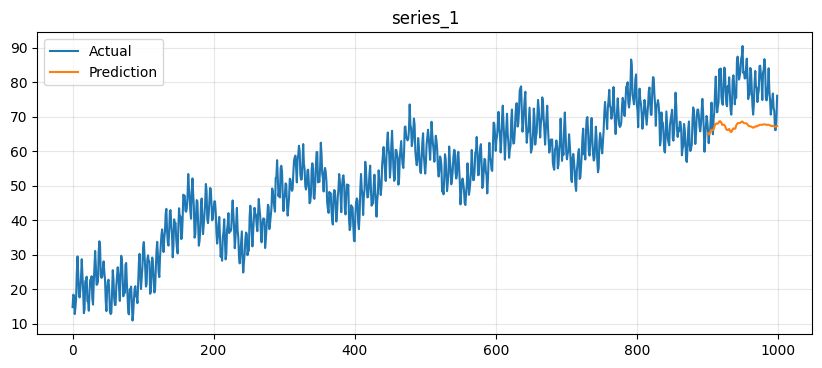

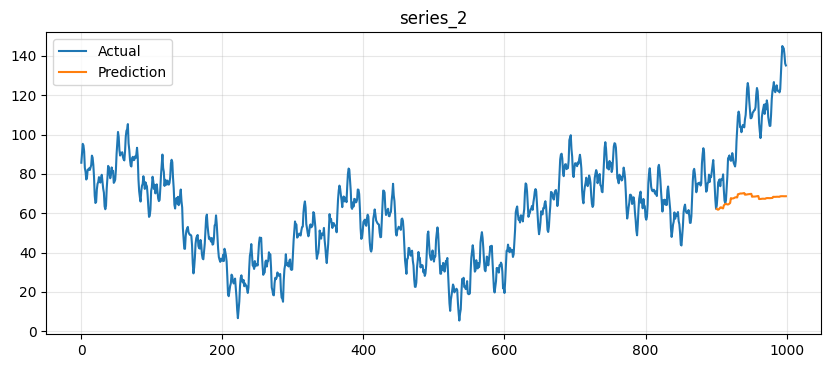

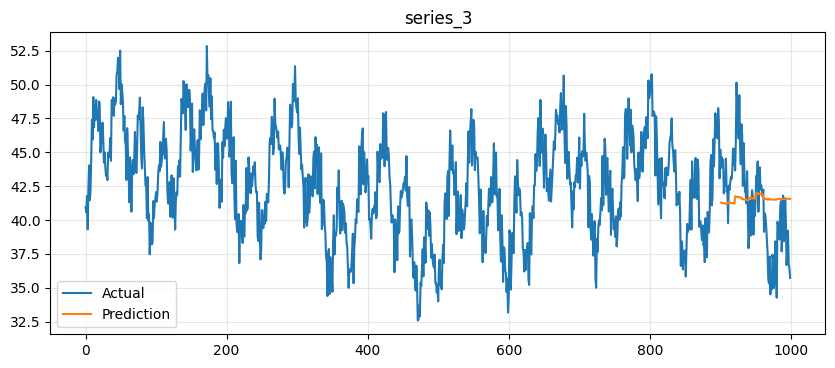

In [22]:
## Check the prediction accuracy
for key in data['series_key'].unique():
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(data[data['series_key']==key]['time_idx'],
             data[data['series_key']==key]['y'], label='Actual')
    plt.plot(prediction[prediction['series_key']==key]['time_idx'],
             prediction[prediction['series_key']==key]['pred'], label='Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(key)
    plt.show()